In [1]:
import yaml
import torch
import time
import numpy as np

from models import EdgeGNN, GAT, GCN, GraphSAGE, GIN, MLP, NodeEdgeGNN, SWEGNN
from data import FloodingEventDataset
from training import NodeRegressionTrainer, EdgeRegressionTrainer, DualRegressionTrainer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [5]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    # debug=True,
                    **config['dataset_parameters']).load()

In [6]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']

## Node and Edge Prediction

In [8]:
def node_edge_loss_func(node_pred, node_label, edge_pred, edge_label):
    loss_func = torch.nn.L1Loss()
    node_loss = loss_func(node_pred, node_label)
    edge_loss = loss_func(edge_pred, edge_label)
    return node_loss + edge_loss

In [9]:
model_params = config['model_parameters']['NodeEdgeGNN']
model = NodeEdgeGNN(**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = node_edge_loss_func

trainer = DualRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 23.6892
Epoch [2/10], Training Loss: 0.0829
Epoch [3/10], Training Loss: 0.0829
Epoch [4/10], Training Loss: 0.0824
Epoch [5/10], Training Loss: 0.0821
Epoch [6/10], Training Loss: 0.0816
Epoch [7/10], Training Loss: 0.0816
Epoch [8/10], Training Loss: 0.0806
Epoch [9/10], Training Loss: 0.0796
Epoch [10/10], Training Loss: 0.0791


Final training Loss: 0.0791
Average training Loss: 2.4422
Minimum training Loss: 0.0791
Maximum training Loss: 23.6892
Total training time: 20.7332 seconds
Validation Loss: 0.0430
Inference time: 0.0022 seconds


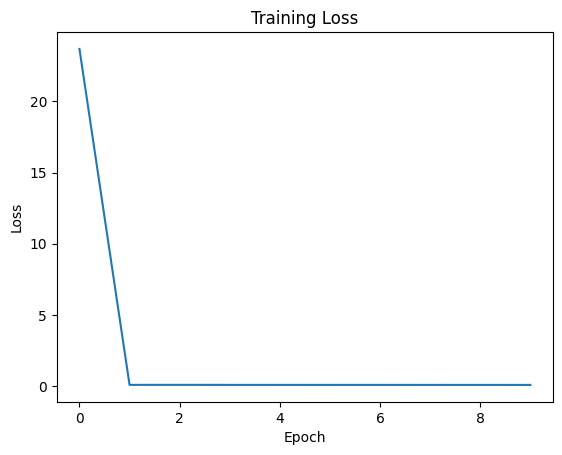

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

In [11]:
# Test with just Node Prediction
model = NodeEdgeGNN(**model_params, **base_model_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()
trainer = DualRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device,
                                mode='node')
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 52.9959
Epoch [2/10], Training Loss: 0.0301
Epoch [3/10], Training Loss: 0.0262
Epoch [4/10], Training Loss: 0.0251
Epoch [5/10], Training Loss: 0.0235
Epoch [6/10], Training Loss: 0.0225
Epoch [7/10], Training Loss: 0.0214
Epoch [8/10], Training Loss: 0.0208
Epoch [9/10], Training Loss: 0.0207
Epoch [10/10], Training Loss: 0.0206


Final training Loss: 0.0206
Average training Loss: 5.3207
Minimum training Loss: 0.0206
Maximum training Loss: 52.9959
Total training time: 18.5701 seconds
Validation Loss: 0.0027
Inference time: 0.0024 seconds


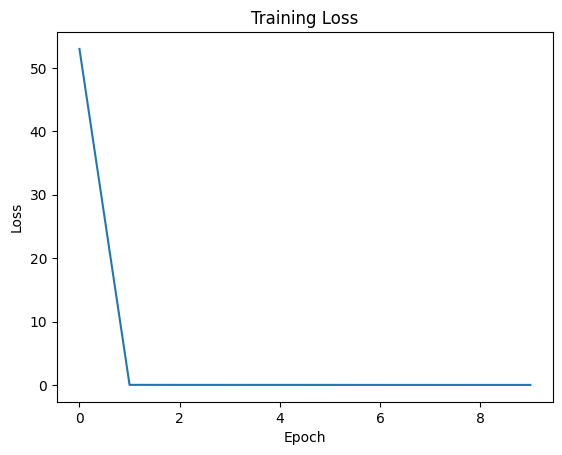

In [12]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Node Prediction Models

In [8]:
node_model_map = {
    'SWEGNN': SWEGNN,
    'GCN': GCN,
    'GAT': GAT,
    'GIN': GIN,
    'GraphSAGE': GraphSAGE,
    'MLP': MLP,
}

In [ ]:
model_name = 'MLP' # Choose from the ff: SWEGNN, GCN, GAT, GIN, GraphSAGE
model_params = config['model_parameters'][model_name]
if model_name == 'MLP':
    model_params['num_nodes'] = len(train_dataset[0].x)
model = node_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = NodeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

c:\Users\Carlo\Documents\School\Masters\NUS\gnn_flood_modeling\venv\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([1268, 1])) that is different to the input size (torch.Size([1268])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Final training Loss: 0.0206
Average training Loss: 0.0217
Minimum training Loss: 0.0206
Maximum training Loss: 0.0293
Total training time: 397.3258 seconds
Validation Loss: 0.0027
Inference time: 0.0526 seconds


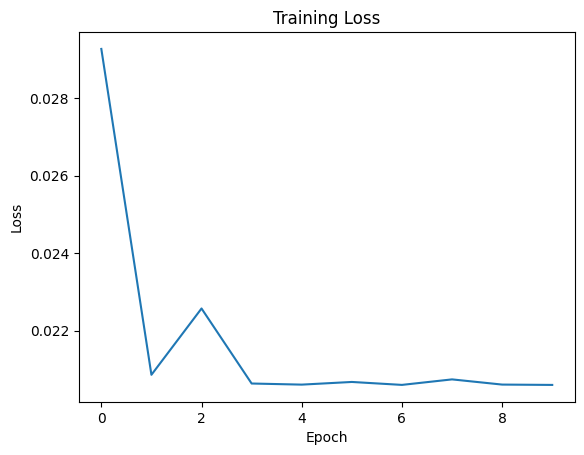

In [10]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Edge Prediction Models

In [11]:
edge_model_map = {
    'EdgeGNN': EdgeGNN,
}

In [12]:
model_name = 'EdgeGNN' # Choose from the ff: EdgeGNN
model_params = config['model_parameters'][model_name]
model = edge_model_map[model_name](**model_params, **base_model_params)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])
loss_func = torch.nn.L1Loss()

trainer = EdgeRegressionTrainer(train_dataset=train_dataset, val_dataset=test_dataset, model=model,
                                loss_func=loss_func, optimizer=optimizer, num_epochs=num_epochs, device=device)
trainer.train()
trainer.validate()

Epoch [1/10], Training Loss: 15.5595
Epoch [2/10], Training Loss: 0.1695
Epoch [3/10], Training Loss: 0.1604
Epoch [4/10], Training Loss: 0.1544
Epoch [5/10], Training Loss: 0.1537
Epoch [6/10], Training Loss: 0.1539
Epoch [7/10], Training Loss: 0.1540
Epoch [8/10], Training Loss: 0.1587
Epoch [9/10], Training Loss: 0.2097
Epoch [10/10], Training Loss: 0.1854


Final training Loss: 0.1854
Average training Loss: 1.7059
Minimum training Loss: 0.1537
Maximum training Loss: 15.5595
Total training time: 9.7774 seconds
Validation Loss: 0.1083
Inference time: 0.0011 seconds


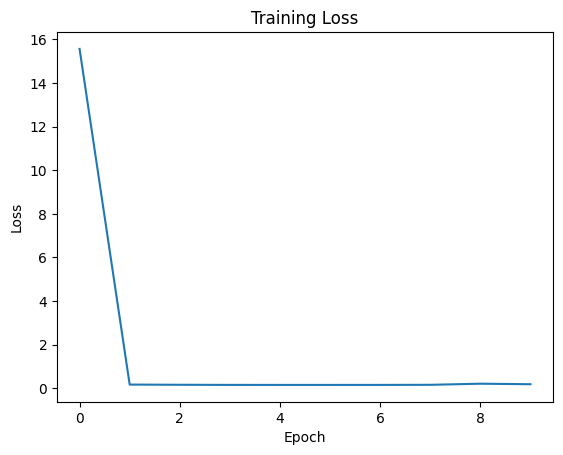

In [13]:
stats = trainer.get_stats()
stats.print_stats_summary()
stats.plot_train_loss()

## Self-Supervised Learning Methods

In [ ]:
from tqdm import tqdm
from models.graph_mae2 import GraphMAE2
from utils.graph_mae2_utils import LinearRegression

In [ ]:
dataset, info = FloodingEventDataset(node_features=config['node_features'],
                    edge_features=config['edge_features'],
                    **config['dataset_parameters']).load()

print(len(dataset))
print(dataset[0])
print(type(dataset[0].x), dataset[0].x.shape)
print(type(dataset[0].edge_index), dataset[0].edge_index.shape)
print(type(dataset[0].edge_attr), dataset[0].edge_attr.shape)
print(type(dataset[0].y), dataset[0].y.shape)
print(info)

336
Data(x=[1268, 6], edge_index=[2, 5224], edge_attr=[5224, 8], y=[1268, 1], pos=[2, 1268])
<class 'torch.Tensor'> torch.Size([1268, 6])
<class 'torch.Tensor'> torch.Size([2, 5224])
<class 'torch.Tensor'> torch.Size([5224, 8])
<class 'torch.Tensor'> torch.Size([1268, 1])
{'num_static_node_features': 3, 'num_dynamic_node_features': 1, 'num_static_edge_features': 5, 'num_dynamic_edge_features': 1, 'previous_timesteps': 2}


In [ ]:
num_train = int(len(dataset) * 0.8) # 80% train, 20% test

train_dataset = dataset[:num_train]
# train_loader = DataLoader(train_dataset) # batch_size=32, shuffle=True

test_dataset = dataset[num_train:]
# test_loader = DataLoader(test_dataset) # batch_size=32, shuffle=True

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
base_model_params = {
    'static_node_features': info['num_static_node_features'],
    'dynamic_node_features': info['num_dynamic_node_features'],
    'static_edge_features': info['num_static_edge_features'],
    'dynamic_edge_features': info['num_dynamic_edge_features'],
    'previous_timesteps': info['previous_timesteps'],
    'device': device,
}
lr_info = config['training_parameters']
model_info = config['model_parameters']

In [ ]:
def pretrain(model, dataset, optimizer):
    start_time = time.time()

    max_epoch = 20
    epoch_iter = tqdm(range(max_epoch))
    model.to(device)
    for epoch in epoch_iter:
        model.train()
        running_loss = 0.0

        for graph in dataset:
            graph = graph.to(device)
            x = graph.x # Target
            target_nodes = torch.arange(x.shape[0], device=device, dtype=torch.long)

            optimizer.zero_grad()

            loss = model(graph, x, targets=target_nodes)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / num_train
        epoch_iter.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Total pre-training time: {(end_time - start_time):4f} seconds')
    return model

def linear_probing(model, dataset, in_dim, out_dim, lr_f, weight_decay_f):
    start_time = time.time()

    decoder = LinearRegression(in_dim, out_dim).to(device)

    num_finetune_params = [p.numel() for p in decoder.parameters() if  p.requires_grad]
    print(f"num parameters for finetuning: {sum(num_finetune_params)}")

    loss_f = torch.nn.MSELoss()
    optimizer_f = torch.optim.Adam(decoder.parameters(), lr=lr_f, weight_decay=weight_decay_f)

    best_model = None
    max_epoch_f = 50
    epoch_iter_f = tqdm(range(max_epoch_f))
    model.eval()
    decoder.train()
    for epoch in epoch_iter_f:
        running_loss = 0.0

        for graph in dataset:
            optimizer_f.zero_grad()

            graph = graph.to(device)
            with torch.no_grad():
                x = model.embed(graph)
                x = x.to(device)
            label = graph.y

            out = decoder(x)
            loss = loss_f(out, label)

            loss.backward()
            optimizer_f.step()
            running_loss += loss.item()

        epoch_loss = running_loss / num_train
        epoch_iter_f.set_description(f"# Epoch {epoch}: train_loss: {epoch_loss:.4f}")

    end_time = time.time()
    print(f'Final loss: {epoch_loss:4f}')
    print(f'Total fine-tuning time: {(end_time - start_time):4f} seconds')

    return decoder

def test_ssl(model, ft_model, dataset, loss_func):
    start_time = time.time()
    model.eval()
    ft_model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for graph in dataset:
            graph = graph.to(device)
            x = model.embed(graph)
            labels = graph.y

            outputs = ft_model(x)

            loss = loss_func(outputs, labels)
            running_loss += loss.item()
    end_time = time.time()

    # Print validation statistics
    print(f'Validation Loss: {running_loss:.4f}')
    print(f'Inference time: {end_time - start_time} seconds')

In [ ]:
graphmae2_params = model_info['GRAPHMAE2']
in_dim = dataset[0].x.shape[1]
model = GraphMAE2(in_dim=in_dim, **graphmae2_params)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_info['learning_rate'], weight_decay=lr_info['weight_decay'])

trained_model = pretrain(model, train_dataset, optimizer)

=== Use sce_loss and alpha_l=3 ===


# Epoch 19: train_loss: 0.0224: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]

Total pre-training time: 95.315137 seconds


In [ ]:
out_dim = dataset[0].y.shape[1]
hidden_dim = graphmae2_params['num_hidden'] // graphmae2_params['nhead']
ft_model = linear_probing(trained_model, train_dataset, hidden_dim, out_dim, 0.0008, lr_info['weight_decay'])

num parameters for finetuning: 2177


# Epoch 49: train_loss: 620.0525: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it] 

Final loss: 620.052530
Total fine-tuning time: 56.627321 seconds


In [ ]:
loss_func = torch.nn.L1Loss()
test_ssl(trained_model, ft_model, test_dataset, loss_func)

Validation Loss: 32728.5642
Inference time: 0.2315971851348877 seconds


In [ ]:
from models.gine.pretrain_contextpred import main

model_file = 'models/gine/trained_model/gine_pretrain'
main(model_file)


cbow
num layer: 5 l1: 4 l2: 7
6
6
6
6
6
====epoch 1


Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([12894, 6])
torch.Size([12894, 1])


Iteration:   0%|          | 0/2 [00:20<?, ?it/s]


RuntimeError: running_mean should contain 1 elements not 6